# Определение возраста покупателей

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

Импортировали библиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Извлекли данные из папки с помощью метода ImageDataGenerator

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


Вывели информацию о датасете, размер датасета и первые 5 строк датасета.

In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
print('Размер датасета -', labels.shape)

Размер датасета - (7591, 2)


In [5]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


В датасете 7591 строк. Колонок только 2: в file_name - названия фотографий, real_age - возраст людей изображенных на фото.

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


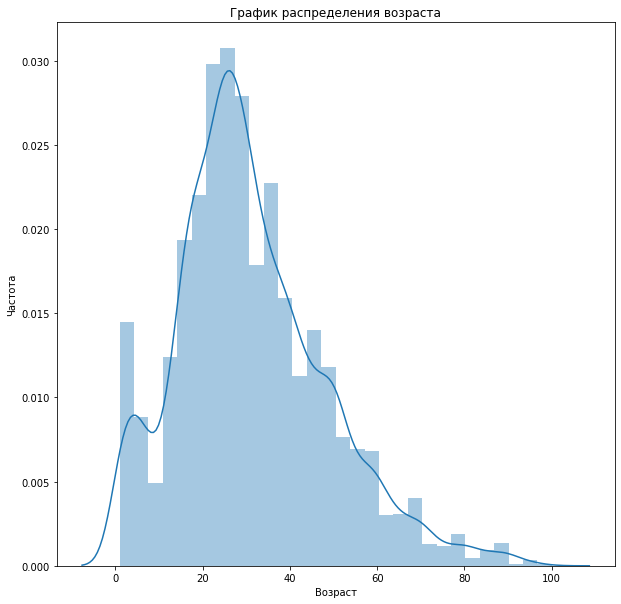

In [6]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.distplot(labels['real_age'], ax=ax, bins=30)
ax.set_title('График распределения возраста')
ax.set_xlabel('Возраст')
ax.set_ylabel('Частота')
plt.show()

По гистограмме можно сказать, что основная возрастная категория людей на фотографиях 25-30 лет, есть фотографии годовалых детей и пенсионеров, но в меньшем количестве. Пики в районе "юбилейных" лет, они тут могут быть связаны с тем, что настоящий возраст был неизвестен тому, кто размещал датасет, и он попросту округлял его. Поэтому, некоторые "круглые" года в датасете некорректные.

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='real_age'>

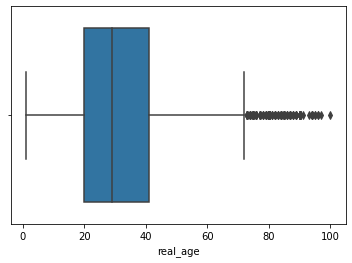

In [7]:
sns.boxplot(labels["real_age"])

По графику boxplot можно сказать, что возраст людей на фотографиях варьируется от 20 до 40 лет. Медианное значение на отметке около 30 лет.

В целом, по графикам можно сказать, что первый график распределения близок  к нормальному, на обоих графиках видно, что после 70 наблюдаются выбросы. Также преимущественное количество фото принадлежит диапазону от примерно 15 до 50 лет.

Далее выведем фотографии на экран

In [8]:
features, target = next(train_gen_flow)

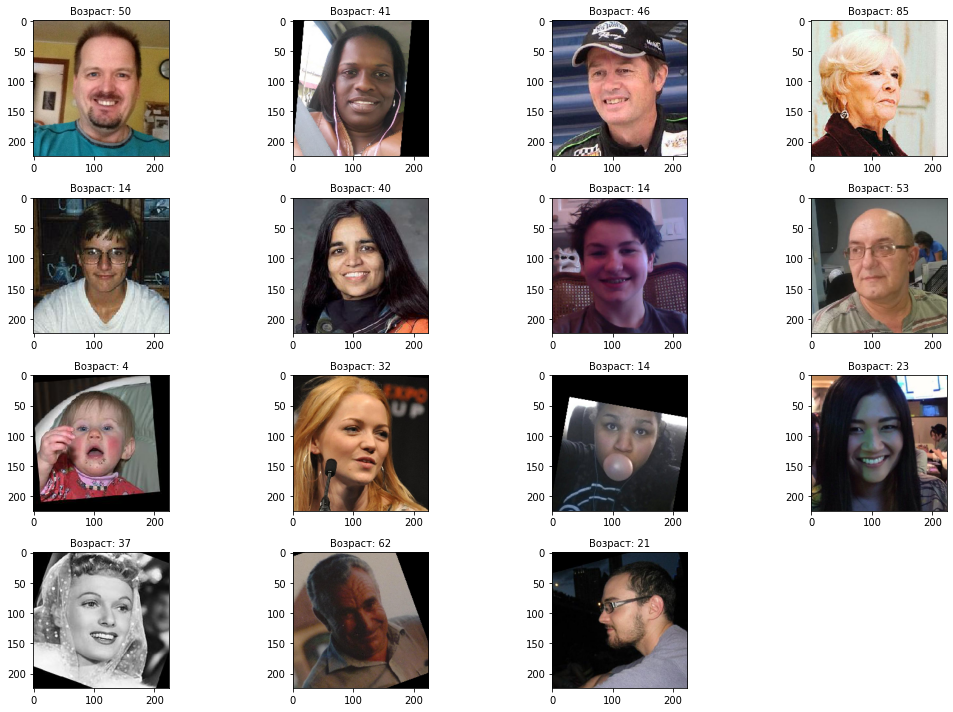

In [9]:
fig = plt.figure(figsize=(15,10))
for i in range(15):
    fig.add_subplot(4,4, i+1)
    plt.title(f'Возраст: {target[i]}', fontsize=10)
    plt.imshow(features[i])
plt.tight_layout()

В наборе присутствуют как цветные и черно-белые фото. Ориентация фото стандартная. Все фото приведеные к одному масштабу.

## Обучение модели

```python

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd


def load_train(path):

    labels = pd.read_csv(path + 'labels.csv')

    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        validation_split=0.2)

    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):

    labels = pd.read_csv(path + 'labels.csv')

    valid_datagen = ImageDataGenerator(
        rescale=1. / 255, 
        validation_split=0.2)

    validation_gen_flow = valid_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return validation_gen_flow

def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```

Epoch 1/10
2022-10-08 05:38:09.126826: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-10-08 05:38:09.730427: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
190/190 - 84s - loss: 242.5991 - mae: 10.9337 - val_loss: 809.0972 - val_mae: 23.3881
Epoch 2/10
190/190 - 39s - loss: 62.7781 - mae: 5.9690 - val_loss: 652.6505 - val_mae: 20.3054
Epoch 3/10
190/190 - 40s - loss: 31.4189 - mae: 4.3281 - val_loss: 199.5787 - val_mae: 10.4056
Epoch 4/10
190/190 - 39s - loss: 20.0146 - mae: 3.4823 - val_loss: 98.3571 - val_mae: 7.3910
Epoch 5/10
190/190 - 40s - loss: 15.3629 - mae: 3.0250 - val_loss: 73.8892 - val_mae: 6.5613
Epoch 6/10
190/190 - 40s - loss: 12.5313 - mae: 2.7461 - val_loss: 65.6236 - val_mae: 6.1673
Epoch 7/10
190/190 - 39s - loss: 11.5499 - mae: 2.5422 - val_loss: 104.7632 - val_mae: 7.7682
Epoch 8/10
190/190 - 39s - loss: 10.8986 - mae: 2.4775 - val_loss: 69.1646 - val_mae: 6.4078
Epoch 9/10
190/190 - 39s - loss: 9.8077 - mae: 2.3456 - val_loss: 64.2019 - val_mae: 6.0977
Epoch 10/10
190/190 - 39s - loss: 7.5990 - mae: 2.0705 - val_loss: 70.0857 - val_mae: 6.1881
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
48/48 - 8s - loss: 70.0857 - mae: 6.1881
Test MAE: 6.1881

```

Модель обучена, достигнут результат отметки MAE ниже 8.

## Анализ обученной модели

Таким образом, модель в среднем ошибается на 6.18 лет.
Модель обучилась за 10 эпох, за основу была взята сеть ResNet50 с отключенными верхними слоями, инициализированы веса ImageNet,
добавлен полносвязный слой с активатором ReLu, функция потерь была задана MSE(из-за того, что использована функция потерь MAE, модель обучилась намного быстрее, чем если бы мы использовали ACC), в качестве оптимизатора был взят Adam c шагом спуска 0.0001.
Такое прогнозирование необходимо принять во внимание при планировании следующих действий, так как ошибка в 6 лет в некоторых случаях может негативно сказаться на бизнесе.